In [ ]:
import os
import json
from PIL import Image
import torch
import torchvision.transforms as T
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Paths to folders
image_folder = "/content/drive/MyDrive/DL Project/Pics/images"
mask_folder = "/content/drive/MyDrive/DL Project/Pics/annotation_mask"
device = torch.device("cuda")

In [ ]:
# Unique RGB colors for each label, including background as black
label_colors = {
    "background": (0, 0, 0),          # Black for background
    "grilled chicken": (255, 0, 0),   # Red
    "paneer": (0, 255, 0),            # Green
    "eggplant": (0, 0, 255)           # Blue
}

In [ ]:
# Convert RGB colors to class indices
color_to_class = {v: i for i, (k, v) in enumerate(
    label_colors.items())}

In [ ]:
# Custom Dataset Class
class FoodSegmentationDataset(Dataset):
    def __init__(self, image_dir, 
                 mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.images = [f for f in os.listdir(image_dir)
                       if f.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        # Load image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        # Convert mask to class indices after transformations
        mask = self.rgb_to_class_indices(mask)

        return image, torch.tensor(mask, dtype=torch.long)

    def rgb_to_class_indices(self, mask):
        mask_np = np.array(mask)
        class_mask = np.zeros((
            mask_np.shape[0], mask_np.shape[1]), dtype=np.int64)
        for color, class_idx in color_to_class.items():
            class_mask[(mask_np == color).all(axis=2)] = class_idx
        return class_mask

In [ ]:
# Data transformations
transform = T.Compose([
    T.Resize((512, 512)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Transformation for masks
mask_transform = T.Resize((512, 512))

In [ ]:
#Dataset and DataLoader
dataset = FoodSegmentationDataset(
    image_folder, mask_folder, transform=transform, mask_transform=mask_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
# Model Class
class EfficientNetSegmentation(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetSegmentation, self).__init__()
        self.backbone = torchvision.models.efficientnet_b0(pretrained=True).features
        self.upsample = nn.Sequential(
            nn.Conv2d(1280, num_classes, kernel_size=1),
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False)
        )

        for param in self.backbone.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.backbone(x)
        x = self.upsample(x)
        return x

model = EfficientNetSegmentation(num_classes=len(label_colors))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Loss and optimizer
class_weights = torch.tensor([0.1, 1.0, 1.0, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
def calculate_iou(pred, target, num_classes):
    pred = pred.argmax(dim=1)
    pred = pred.to(device)
    target = target.to(device)

    iou_list = []
    for cls in range(num_classes):
        pred_mask = (pred == cls)
        target_mask = (target == cls)
        intersection = (pred_mask & target_mask).sum().float()
        union = (pred_mask | target_mask).sum().float()
        if union == 0:
            iou = torch.tensor(1.0, device=device) if intersection == 0 else torch.tensor(0.0, device=device)
        else:
            iou = intersection / union
        iou_list.append(iou)
    return torch.mean(torch.stack(iou_list))


In [ ]:
# Training function with IoU calculation, model saving, and graph plotting
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    model = model.to(device)
    train_losses = []
    val_losses = []
    iou_scores = []
    best_iou = 0.0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        scheduler.step()

        # Validation
        model.eval()
        val_loss = 0
        iou = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                iou += calculate_iou(outputs, masks, num_classes=len(label_colors))

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        iou /= len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        iou_scores.append(iou.item())

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, IoU: {iou:.4f}")

        # Save the best model based on IoU
        if iou > best_iou:
            best_iou = iou
            best_model = model.state_dict()
            torch.save(best_model, "/content/best_model.pth")

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot IoU graph
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), iou_scores, label='IoU', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title('IoU Over Epochs')
    plt.legend()
    plt.show()

    print(f"Best IoU: {best_iou:.4f} achieved with the saved model.")
    return best_iou


In [ ]:
def visualize_predictions(model, dataloader):
    model.eval()
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(1).cpu().numpy()

            for i in range(len(images)):
                pred_rgb = np.zeros((preds[i].shape[0], preds[i].shape[1], 3), dtype=np.uint8)
                mask_rgb = np.zeros((masks[i].shape[0], masks[i].shape[1], 3), dtype=np.uint8)

                for color, class_idx in color_to_class.items():
                    pred_rgb[preds[i] == class_idx] = color
                    mask_rgb[masks[i].cpu().numpy() == class_idx] = color


                title_text = "Prediction"

                # Plot the images
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                axs[0].imshow(images[i].cpu().permute(1, 2, 0))
                axs[0].set_title("Input Image")
                axs[1].imshow(mask_rgb)
                axs[1].set_title("Ground Truth Mask")
                axs[2].imshow(pred_rgb)
                axs[2].set_title(title_text)
                plt.show()
                break

Epoch 1/30, Training Loss: 1.1172, Validation Loss: 0.8474, IoU: 0.3076
Epoch 2/30, Training Loss: 0.8465, Validation Loss: 0.6065, IoU: 0.3401
Epoch 3/30, Training Loss: 0.7108, Validation Loss: 0.6694, IoU: 0.3401
Epoch 4/30, Training Loss: 0.6605, Validation Loss: 0.5098, IoU: 0.3558
Epoch 5/30, Training Loss: 0.7324, Validation Loss: 0.8833, IoU: 0.3197
Epoch 6/30, Training Loss: 0.6715, Validation Loss: 0.5341, IoU: 0.3949
Epoch 7/30, Training Loss: 0.5274, Validation Loss: 0.4938, IoU: 0.3628
Epoch 8/30, Training Loss: 0.5224, Validation Loss: 0.4982, IoU: 0.3826
Epoch 9/30, Training Loss: 0.4907, Validation Loss: 0.5015, IoU: 0.3812
Epoch 10/30, Training Loss: 0.4865, Validation Loss: 0.4425, IoU: 0.4504
Epoch 11/30, Training Loss: 0.4527, Validation Loss: 0.5656, IoU: 0.3831
Epoch 12/30, Training Loss: 0.4492, Validation Loss: 0.4621, IoU: 0.4030
Epoch 13/30, Training Loss: 0.4166, Validation Loss: 0.5103, IoU: 0.3922
Epoch 14/30, Training Loss: 0.4056, Validation Loss: 0.4331,

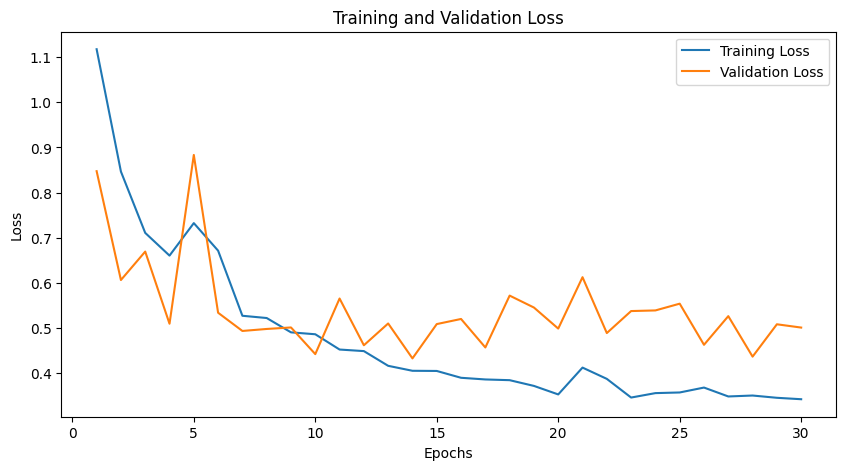

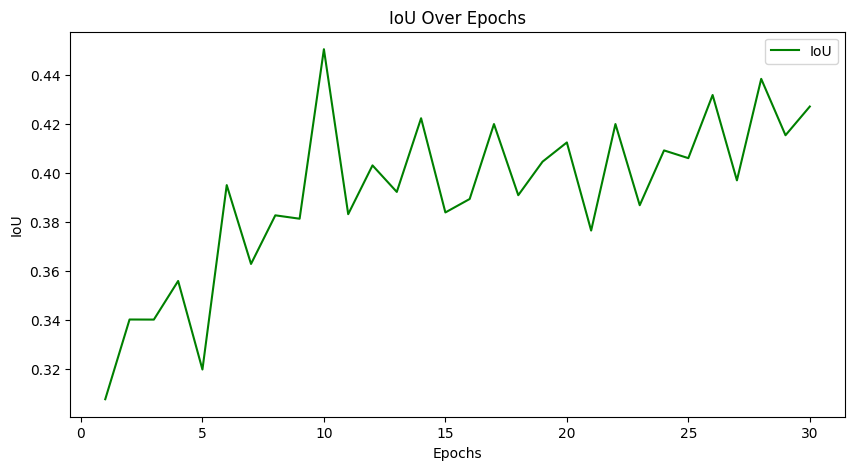

Best IoU: 0.4504 achieved with the saved model.


In [ ]:
# Train the model and visualize
best_iou = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs = 30)

In [ ]:
# Define paths and ensure the checkpoint exists
best_model_path = os.path.join("/content/", 'best_model.pth')

if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    print("Best model loaded successfully.")
else:
    print("Best model checkpoint not found!")

Best model loaded successfully.


<ipython-input-19-192478864cd0>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


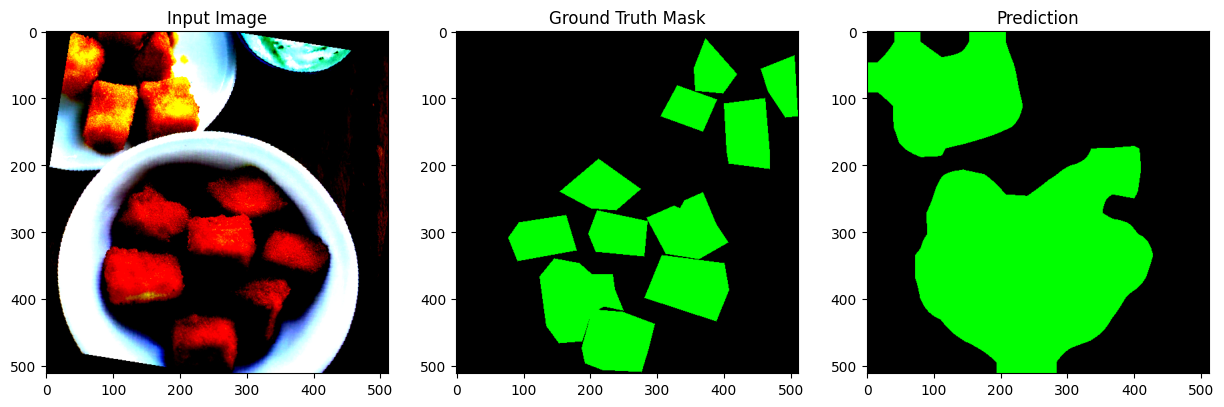

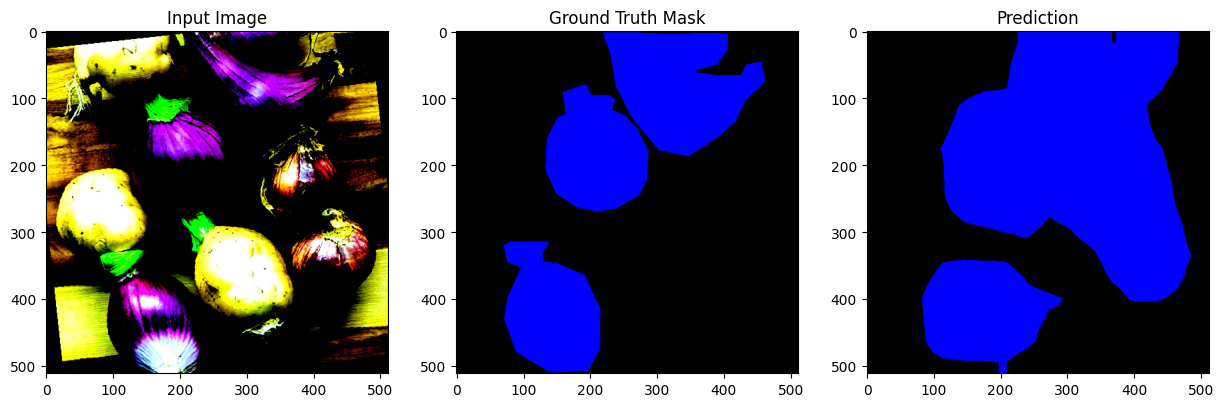

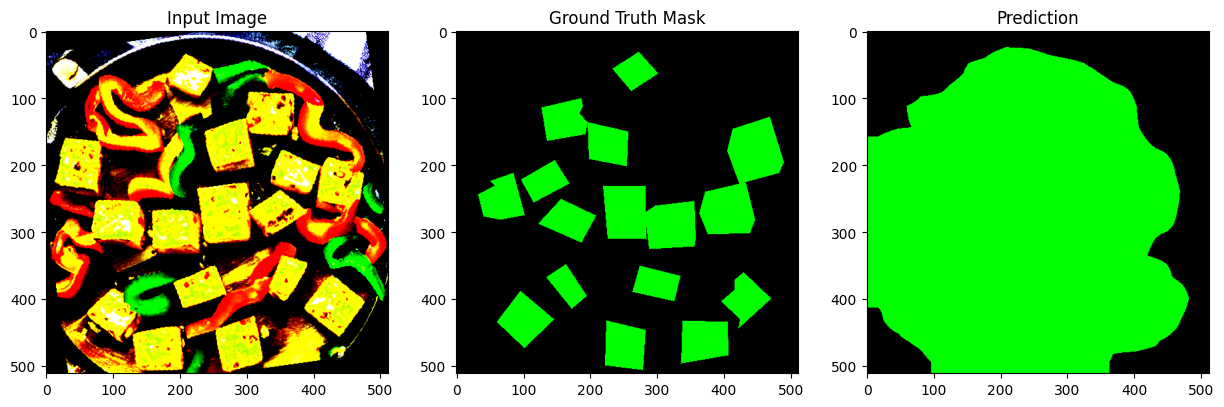

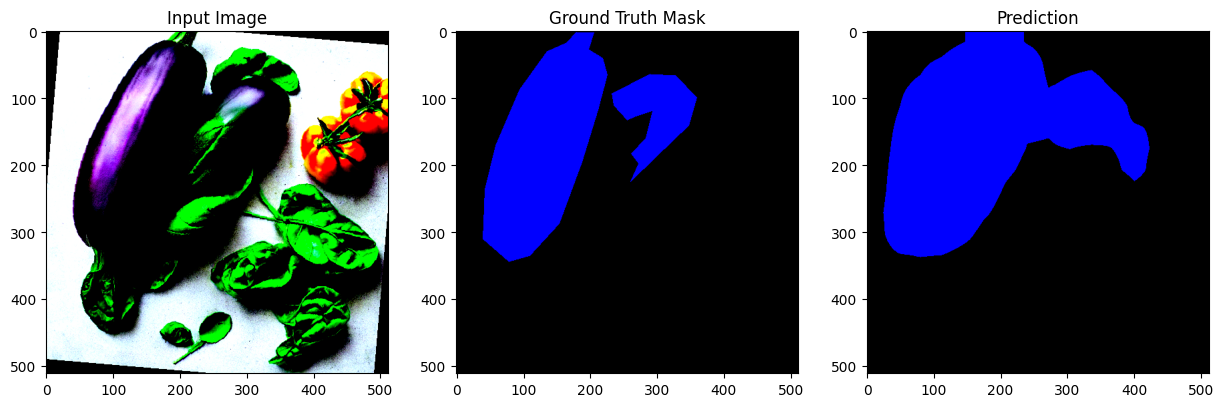

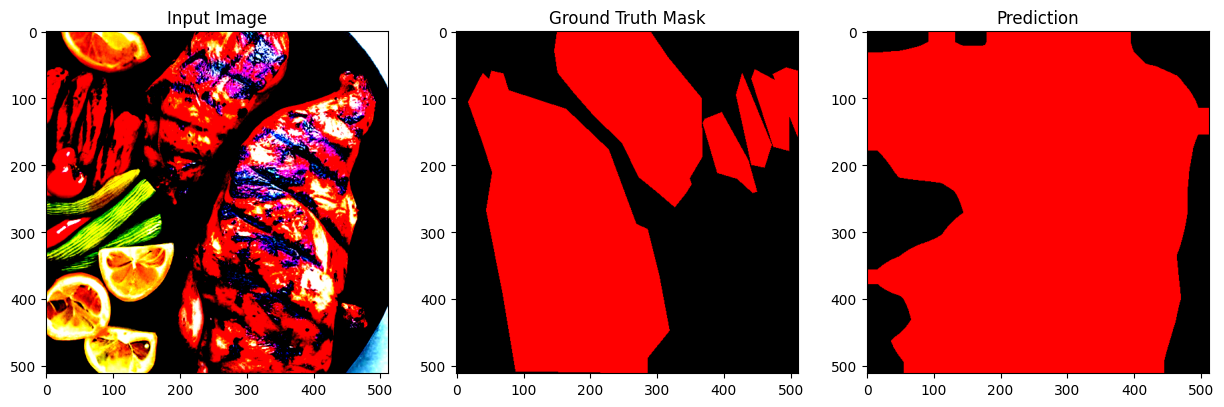

In [ ]:
visualize_predictions(model, val_loader)